In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sigma = 1.  # Standard deviation.
mu = 10.  # Mean.
tau = .05  # Time constant.

In [3]:
dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

In [4]:
sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

In [5]:
x = np.zeros(n)

Euler-Maruyama induces and interative map

In [7]:
for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + sigma_bis * sqrtdt * np.random.randn()

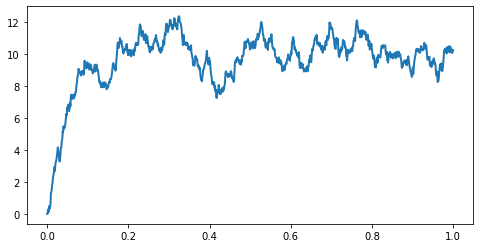

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)

Multiple trials 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


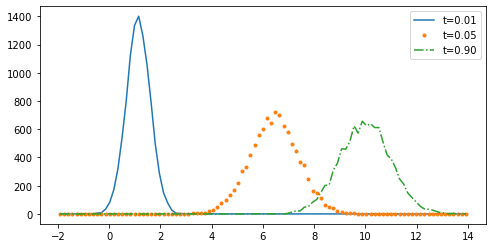

In [9]:
ntrials = 10000
X = np.zeros(ntrials)
# We create bins for the histograms.
bins = np.linspace(-2., 14., 100)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in range(n):
    # We update the process independently for
    # all trials
    X += dt * (-(X - mu) / tau) + sigma_bis * sqrtdt * np.random.randn(ntrials)
    # We display the histogram for a few points in
    # time
    if i in (5, 50, 900):
        hist, _ = np.histogram(X, bins=bins)
        ax.plot((bins[1:] + bins[:-1]) / 2, hist,
                {5: '-', 50: '.', 900: '-.', }[i],
                label=f"t={i * dt:.2f}")
    ax.legend()
    

# Noisy saddle

## Sanity test: RK4 integration 

In [2]:
import numpy as np
from pylds.tools import draw_all_lds
from pylds.base import compute_lagrangian_descriptor

### Define vector field

In [1]:
def Saddle1D(t, u, PARAMETERS = [1, 1]):
    """
    Returns 1D Hamilton-Saddle vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [lamda]
    Functional form: v = (lamda*y, - lamda*x), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    PARAMETERS : list of floats
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x, y = u.T
    # Hamiltonian Model Parameter
    a1, a2 = PARAMETERS
    v = np.column_stack([ a1*x, -a2*y])
    return v

### Solve with RK4 (built-in)

Input parameters

In [3]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.1

# Mesh parameters
x_min,x_max = [-1, 1]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [4]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [5]:
vector_field = Saddle1D

In [6]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value=0.5)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value=0.5)

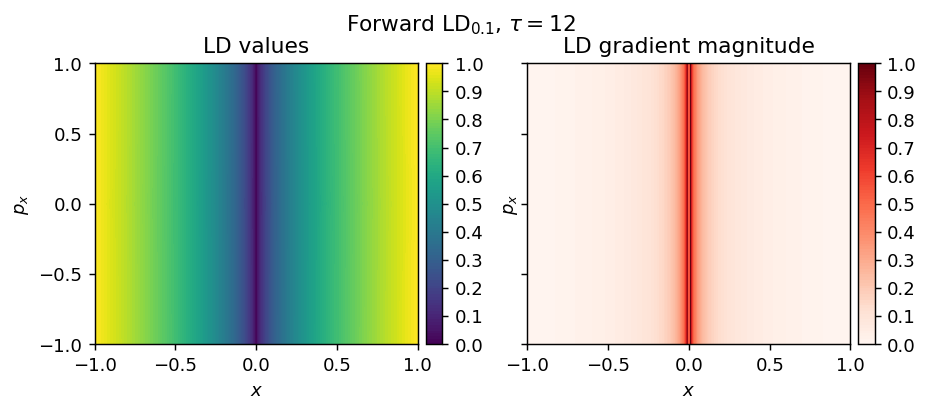

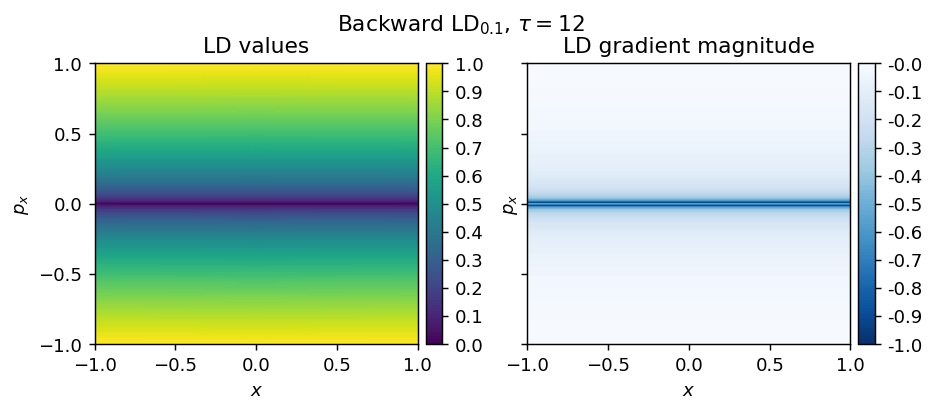

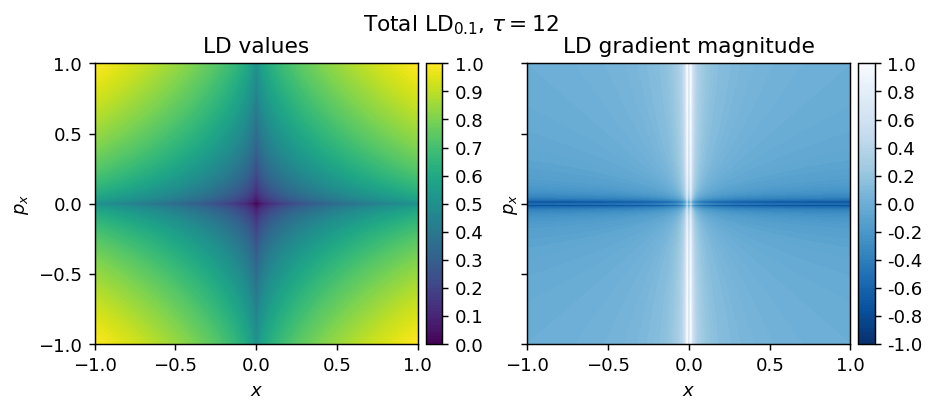

In [7]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

## Define Euler-Maruyama integrator

In [26]:
import numpy as np
from pylds.tools import draw_all_lds
from pylds.base import generate_points, compute_lagrangian_descriptor, lagrangian_descriptor

__INTEGRATOR: FORWARD TRAJECTORIES__

In [27]:
def euler_solver_forward(u, v, dt, noise_amplitude = [0, 0]):
    """
    Returns vector field for a perturbation at time t, for an array of points in phase space.
    Number of model parameters: 3. perturbation_params = [perturbation_type, amplitude, frequency]
    Functional form: v = (, ), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    perturbation_params : list of floats, [perturbation_type, amplitude, frequency]
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    # iterative solver
    b = np.array(noise_amplitude)
    dW = np.random.randn(*u.shape)
    u = u + v(0, u)*dt + b*dW*dt

    return u

__INTEGRATOR: BACKWARD TRAJECTORIES__

In [28]:
def euler_solver_backward(u, v, dt, noise_amplitude = [0, 0]):
    """
    Returns vector field for a perturbation at time t, for an array of points in phase space.
    Number of model parameters: 3. perturbation_params = [perturbation_type, amplitude, frequency]
    Functional form: v = (, ), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    perturbation_params : list of floats, [perturbation_type, amplitude, frequency]
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    # iterative solver
    b = np.array(noise_amplitude) #noise amplitude
    dW = np.random.randn(*u.shape)
    u = u - v(0, u)*dt + b*dW*dt

    return u

LD CALCULATOR FOR ITERATIVE MAPS

In [29]:
def compute_lagrangian_descriptor(grid_parameters, discrete_map, N_iterations, p_value=0.5):
    """
    Returns the values of the LD function from trajectories from iterated initial conditions in plane by a map.
    
    Parameters
    ----------
    grid_parameters : list of 3-tuples of floats
        input parameters of limits and size of mesh per axis.
    
    discrete_map: function
        map of discrete 2D dynamical system.
        
    tau : float
        Upper limit of integration.
        
    p_value : float, optional
        Exponent in Lagrangian descriptor definition.
        0 is the acton-based LD,
        0 < p_value < 1 is the Lp quasinorm,
        1 <= p_value < 2 is the Lp norm LD,
        2 is the arclength LD.
        The default is 0.5.
    
    box_boundaries : list of 2-tuples, optional
        Box boundaries for escape condition of variable time integration.
        Boundaries are infinite by default.
        
    perodic_boundaries: list of floats
        Lenght values of periodic box axes (2D default).
        PBC are False by default.
    Returns
    -------
    LD : ndarray, shape (Nx, Ny)
        Array of computed Lagrangian descriptor values for all initial conditions.
    """
    N_mesh_axes = len(grid_parameters)+1
    y0, mask = generate_points(grid_parameters)
    y0 = y0.reshape(-1,N_mesh_axes)
    y0 = y0[:,:-1] # exclude LD-axis
        
    f = discrete_map

    LD_values = np.zeros(len(y0))
    for i in range(N_iterations):
        y = f(y0)
        dy = y-y0                
        LD_values = LD_values + lagrangian_descriptor(y0, dy, p_value)
        y0 = y

    N_points_slice_axes = [x[-1] for x in grid_parameters] #take number of points
    LD = LD_values.reshape(*N_points_slice_axes) #reshape to 2-D array  

    if p_value<=1:
        return LD
    else:
        return LD**(1/p_value)

## TEST: Euler-Maruyama __without__ noise

Input parameters

In [51]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 0.1

# Mesh parameters
x_min,x_max = [-1, 1]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [52]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [53]:
vector_field = Saddle1D

NameError: name 'Saddle1D' is not defined

Additional input parameters

In [12]:
dt = 0.05
N_iterations = int(tau/dt)

In [13]:
noise_amplitude = [0, 0]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [14]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value=0.5)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value=0.5)

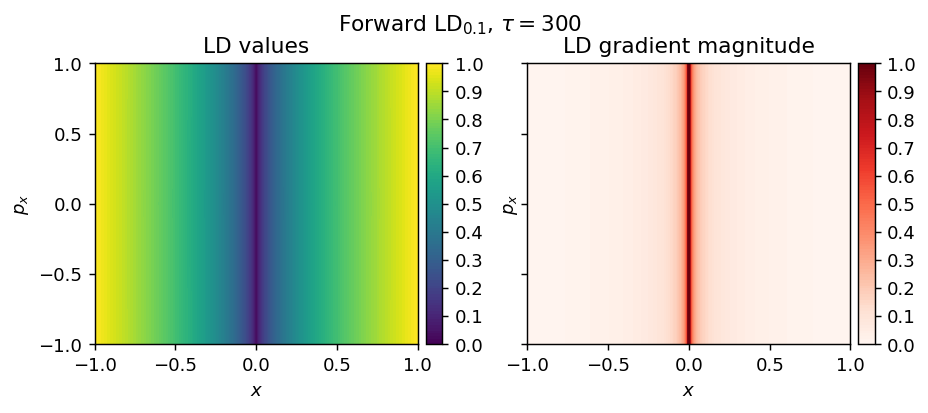

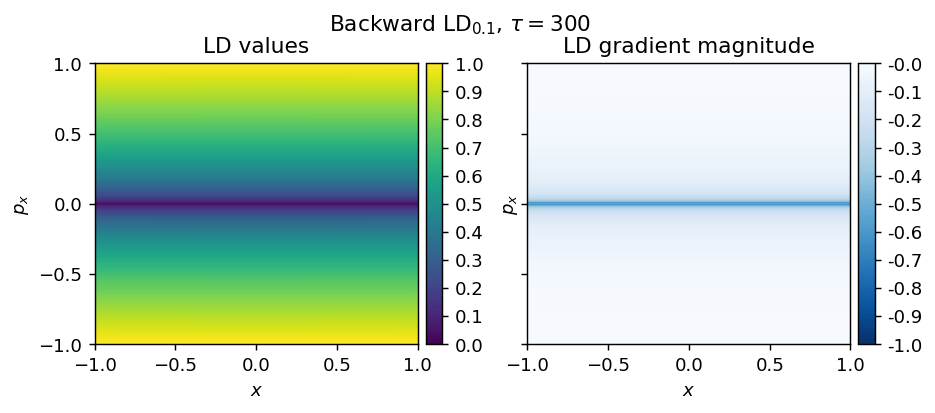

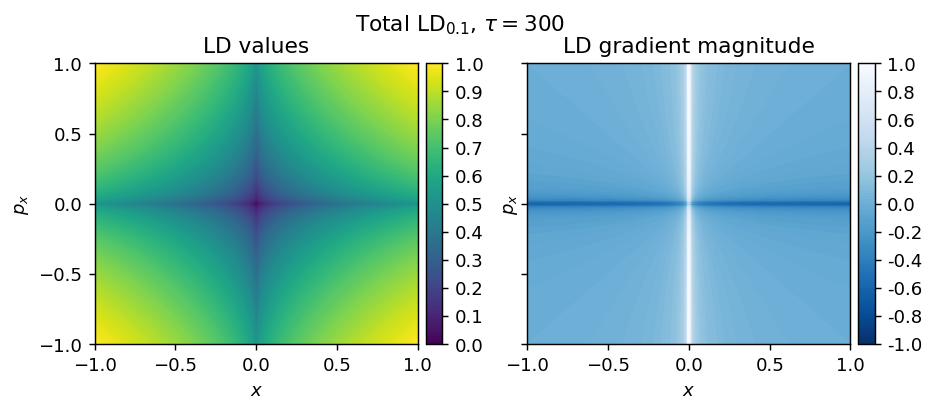

In [15]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TEST: Euler-Maruyama __with__ noise

Input parameters

In [7]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 0.1

# Mesh parameters
x_min,x_max = [-1, 1]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [8]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [9]:
vector_field = Saddle1D

Additional input parameters

In [10]:
dt = 0.05
N_iterations = int(tau/dt)

In [11]:
noise_amplitude = [-1, 1]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [12]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value)

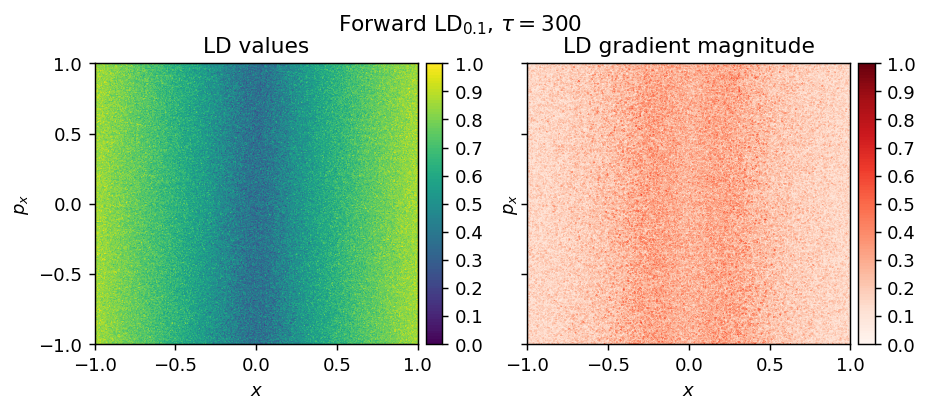

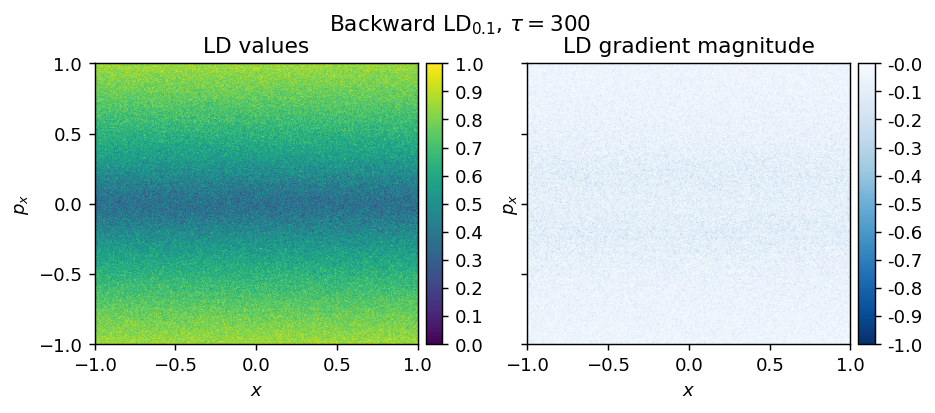

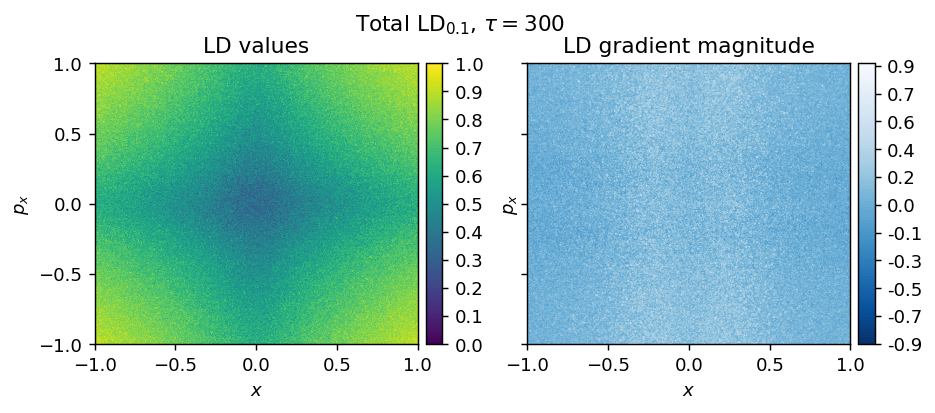

In [22]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TES: Several experiments

In [60]:
N_trials = 100

In [61]:
LD_total_trials = []

In [62]:
for n in range(N_trials):
    LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value=0.5)
    LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value=0.5)
    LD_total = LD_forward + LD_backward
    
    LD_total_trials.append(LD_total)

In [63]:
LD_total_mean = np.array(LD_total_trials).mean(axis=0)

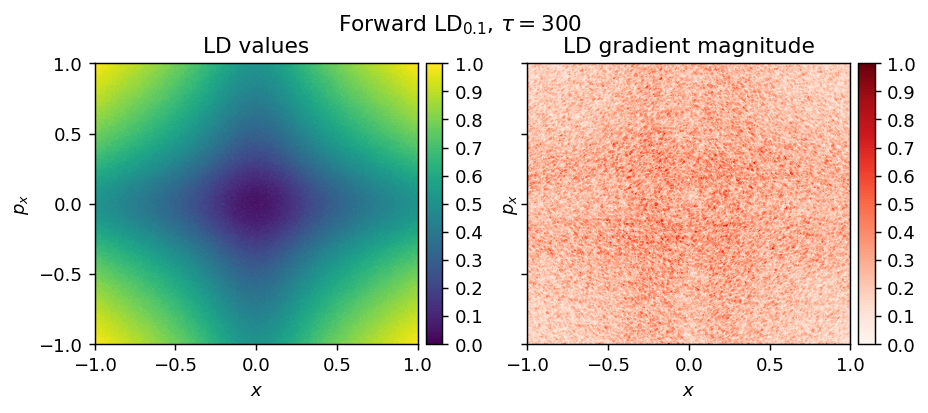

In [64]:
p = draw_all_lds(LD_total_mean, [], grid_parameters, N_iterations, p_value)

# Duffing oscillator

In [3]:
import numpy as np
from pylds.tools import draw_all_lds
from pylds.base import compute_lagrangian_descriptor

### Define vector field

In [1]:
def Duffing1D(t, u, PARAMETERS = [1, 1, -1]):
    """
    Returns 1D Hamilton-Saddle vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [lamda]
    Functional form: v = (lamda*y, - lamda*x), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    PARAMETERS : list of floats
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x, y = u.T
    # Hamiltonian Model Parameter
    alpha, beta, gamma = PARAMETERS
    v = np.column_stack([ alpha*y, beta*x + gamma*x**3])
    return v

### Solve with RK4 (built-in)

Input parameters

In [4]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [5]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [6]:
vector_field = Duffing1D

In [7]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

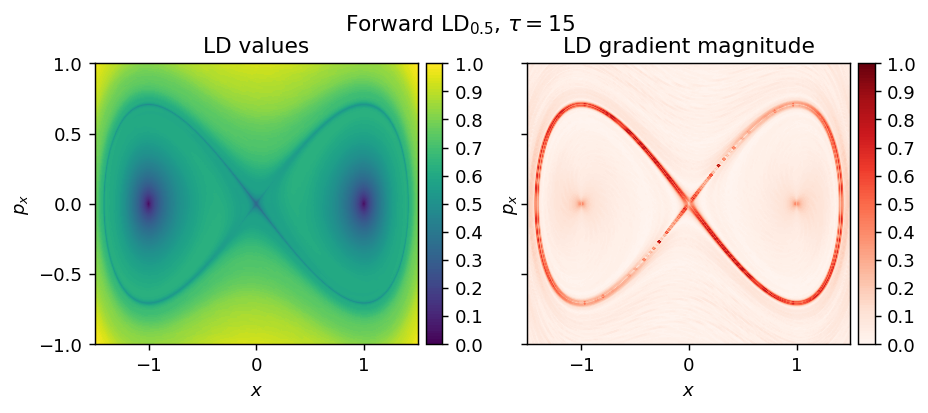

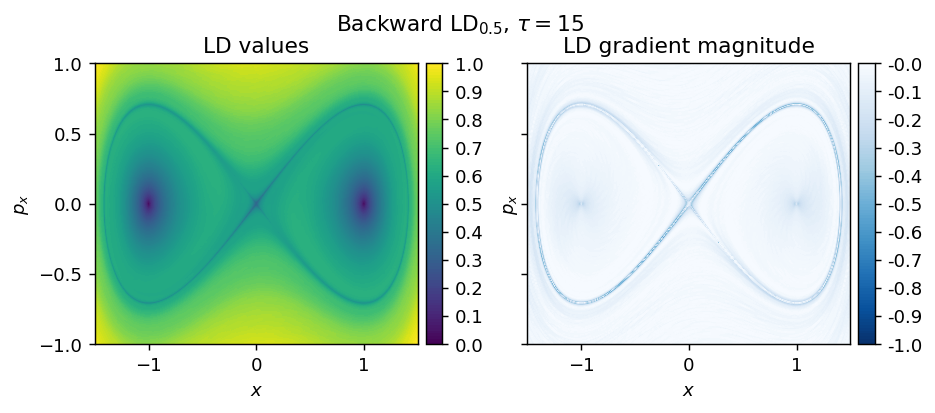

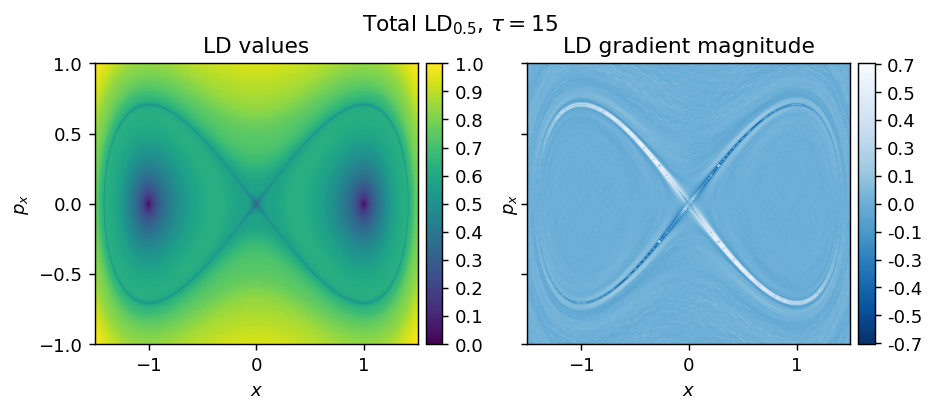

In [8]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

## TEST: Euler-Maruyama __without__ noise

Input parameters

In [9]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

In [10]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [11]:
vector_field = Duffing1D

Additional input parameters

In [12]:
dt = 0.05
N_iterations = int(tau/dt)

In [17]:
noise_amplitude = [0, 0]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [25]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value)

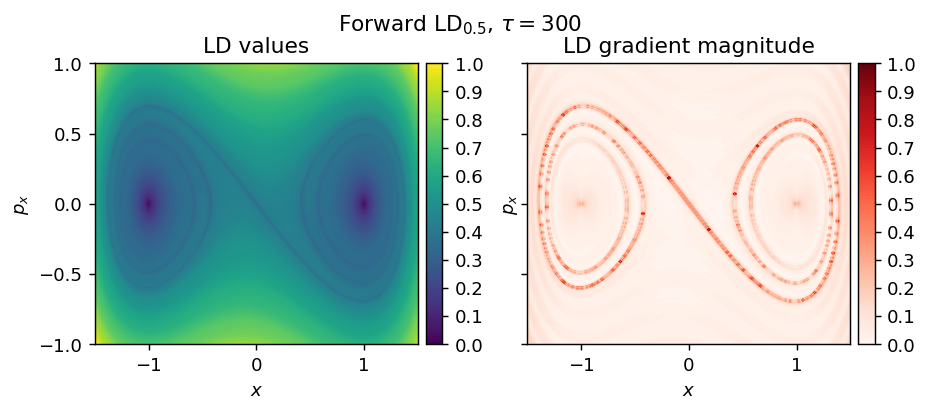

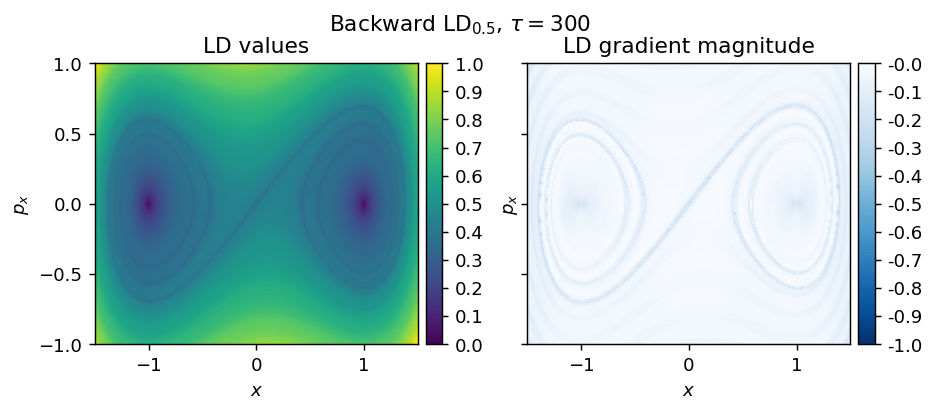

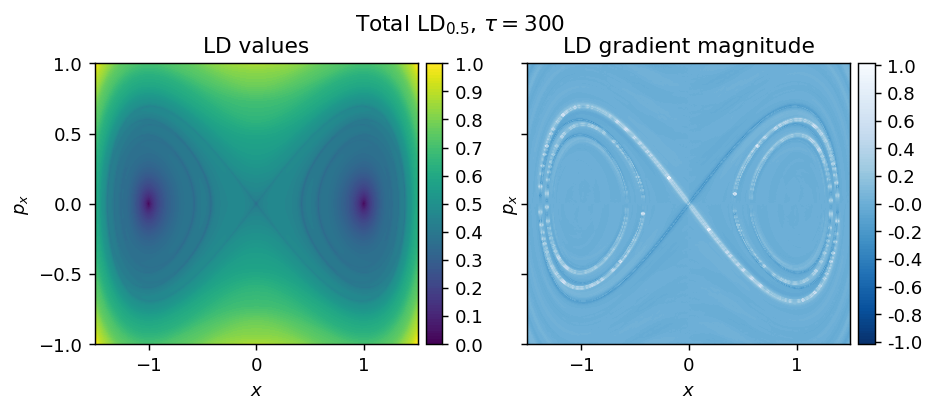

In [26]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TEST: Euler-Maruyama __with__ noise

Input parameters

In [34]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]
Nx, Ny = [500, 500]

In [35]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [36]:
vector_field = Duffing1D

Additional input parameters

In [37]:
dt = 0.05
N_iterations = int(tau/dt)

In [38]:
noise_amplitude = [0, 0.25]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [39]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value)

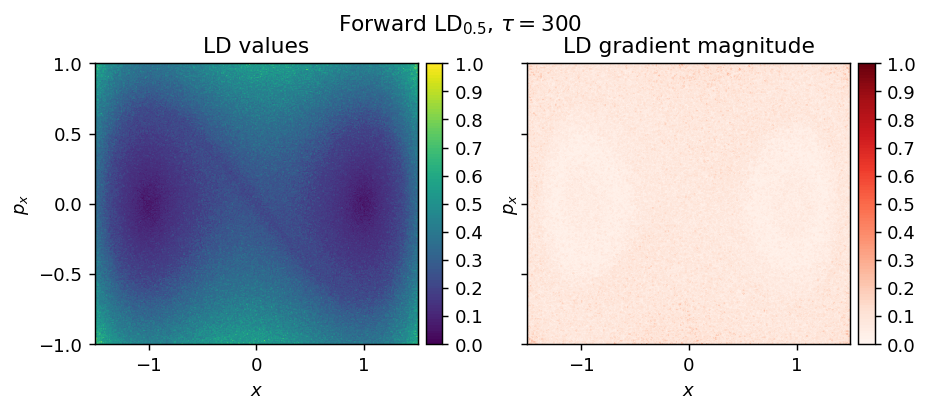

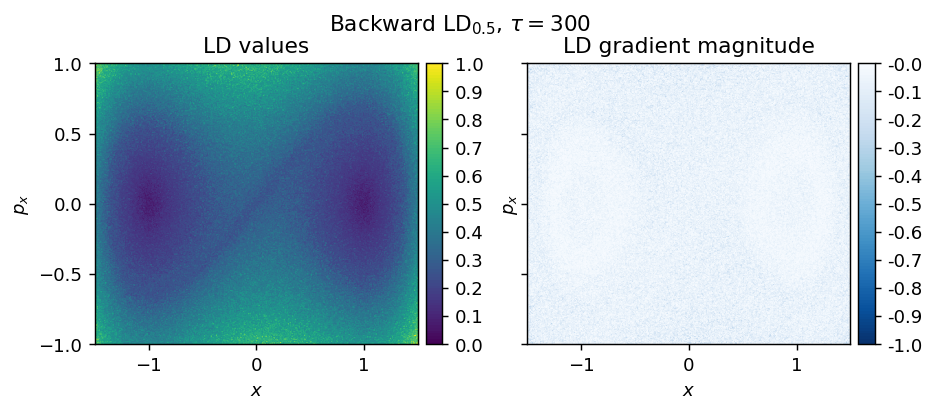

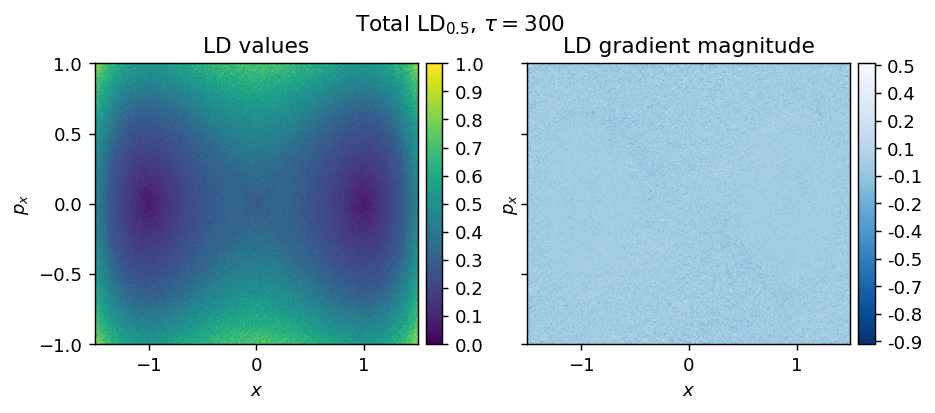

In [40]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TES: Several experiments

In [41]:
N_trials = 100

In [42]:
LD_total_trials = []

In [43]:
for n in range(N_trials):
    LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value=0.5)
    LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value=0.5)
    LD_total = LD_forward + LD_backward
    
    LD_total_trials.append(LD_total)

In [44]:
LD_total_mean = np.array(LD_total_trials).mean(axis=0)

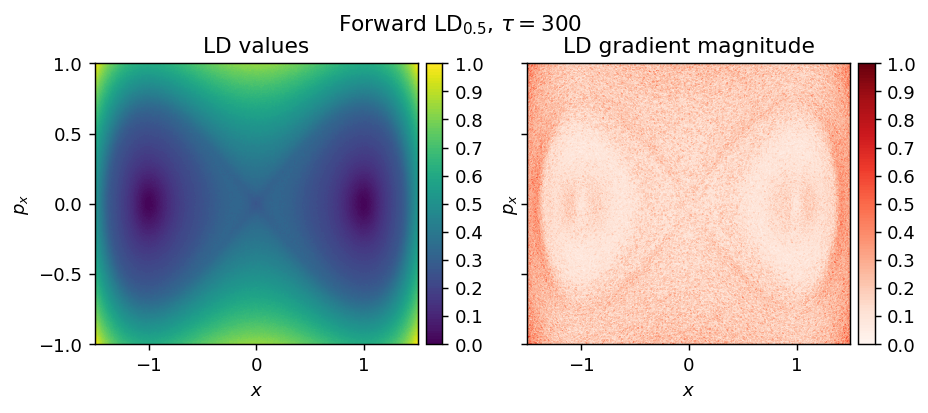

In [45]:
p = draw_all_lds(LD_total_mean, [], grid_parameters, N_iterations, p_value)

# Double gyre

In [50]:
import numpy as np
from pylds.tools import draw_all_lds
from pylds.base import compute_lagrangian_descriptor

## Sanity test: RK4 integration

### Define vector field

In [51]:
def DoubleGyre(t, u, PARAMETERS = [0.25, 2*np.pi, 0, 0, 1, 0.25]):
    """
    Returns 1D Double Gyre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [lamda]
    Functional form: v = (lamda*y, - lamda*x), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    PARAMETERS : list of floats
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x, y = u.T
    # model parameter
    A, phi, psi, mu, s, epsilon = PARAMETERS
    # vector field components
    def f(t, x): return epsilon*np.sin(phi*t + psi)*x**2 + (1-2*epsilon*np.sin(phi*t + psi))*x
    def df_dx(t,x): return 2*epsilon*np.sin(phi*t + psi)*x + (1-2*epsilon*np.sin(phi*t + psi))
    v_x = -np.pi*A*np.sin(np.pi*f(t, x)/s)*np.cos(np.pi*y/s) - mu*x
    v_y =  np.pi*A*np.cos(np.pi*f(t, x)/s)*np.sin(np.pi*y/s)*df_dx(t,x) - mu*y
    v   = np.column_stack([ 
        v_x, 
        v_y
    ])
    return v

### Solve with RK4 (built-in)

Input parameters

In [52]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [0, 2]
y_min,y_max = [0, 1]
Nx, Ny = [600, 600]

In [53]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [54]:
vector_field = DoubleGyre

In [55]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

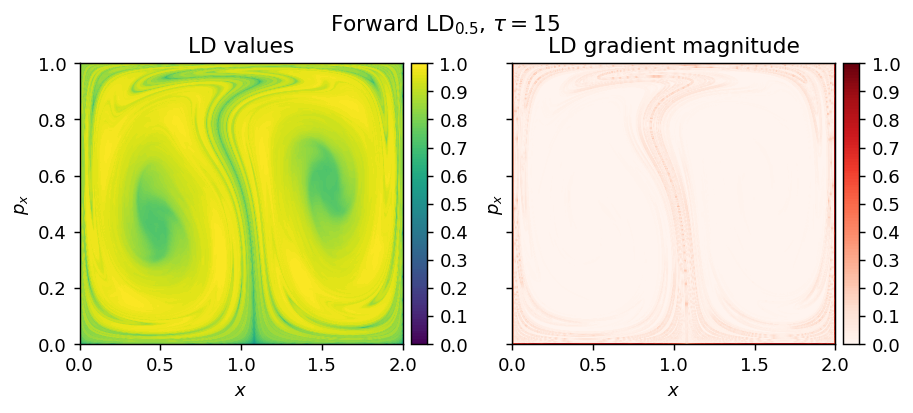

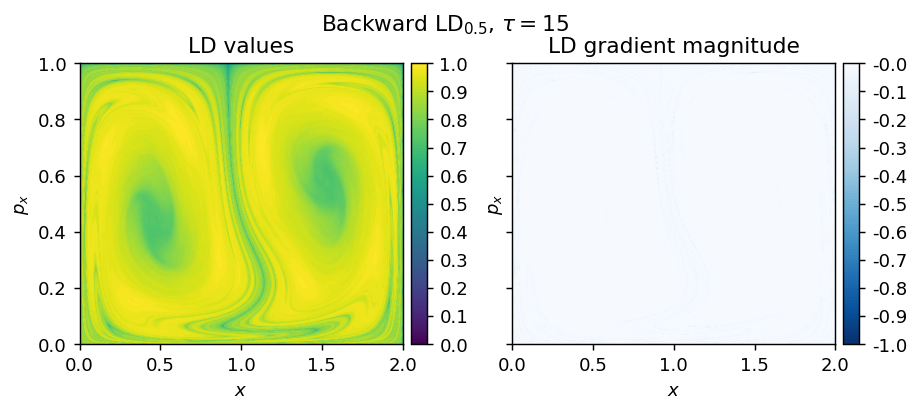

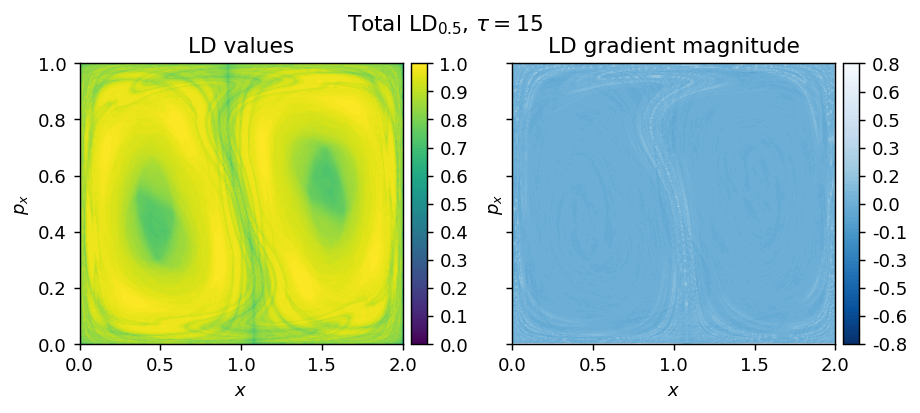

In [56]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

## TEST: Euler-Maruyama __without__ noise

Input parameters

In [15]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [0, 2]
y_min,y_max = [0, 1]
Nx, Ny = [600, 600]

In [16]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [17]:
vector_field = DoubleGyre

Additional input parameters

In [18]:
dt = 0.05
N_iterations = int(tau/dt)

In [19]:
noise_amplitude = [0, 0]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [30]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value)

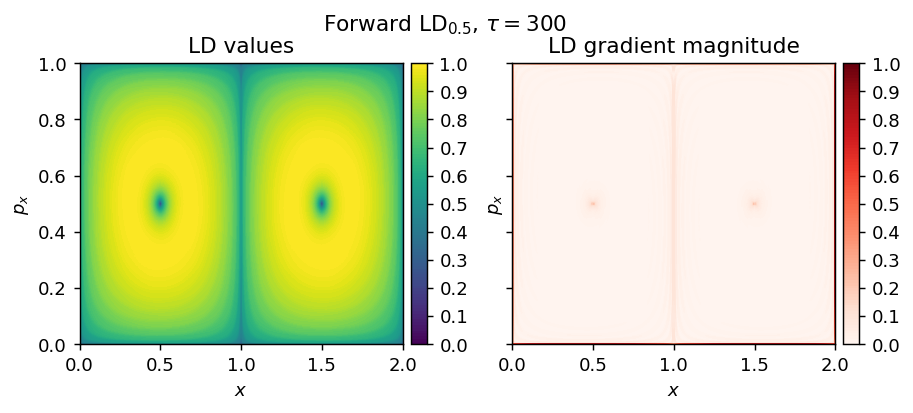

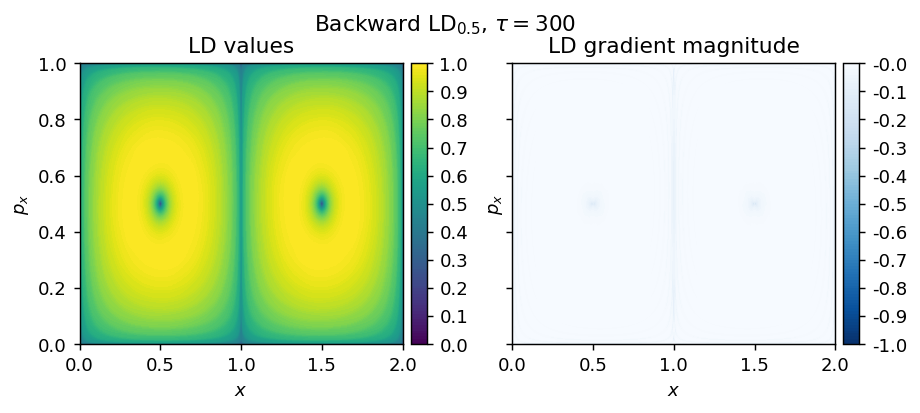

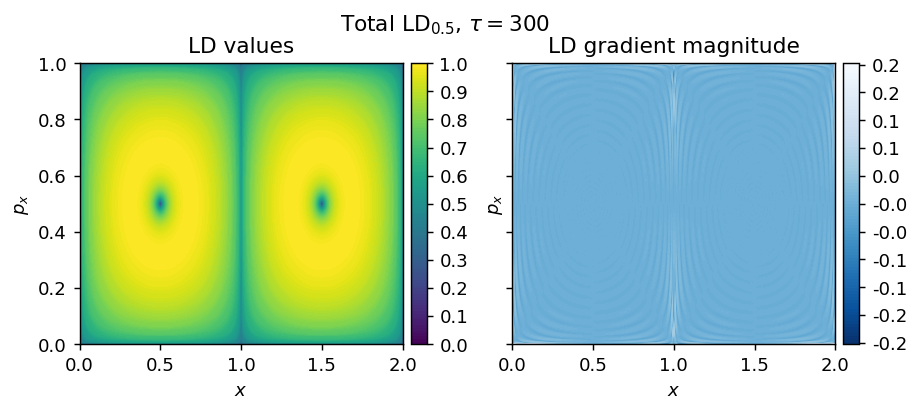

In [31]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TEST: Euler-Maruyama __with__ noise

Input parameters

In [32]:
# Integration parameters
tau = 15

# LDp, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [0, 2]
y_min,y_max = [0, 1]
Nx, Ny = [500, 500]

In [33]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [34]:
vector_field = DoubleGyre

Additional input parameters

In [35]:
dt = 0.05
N_iterations = int(tau/dt)

In [36]:
noise_amplitude = [0.1, 0.1]

discrete_map_forward = lambda u : euler_solver_forward(u, vector_field, dt, noise_amplitude)
discrete_map_backward = lambda u : euler_solver_backward(u, vector_field, dt, noise_amplitude)

In [37]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value)

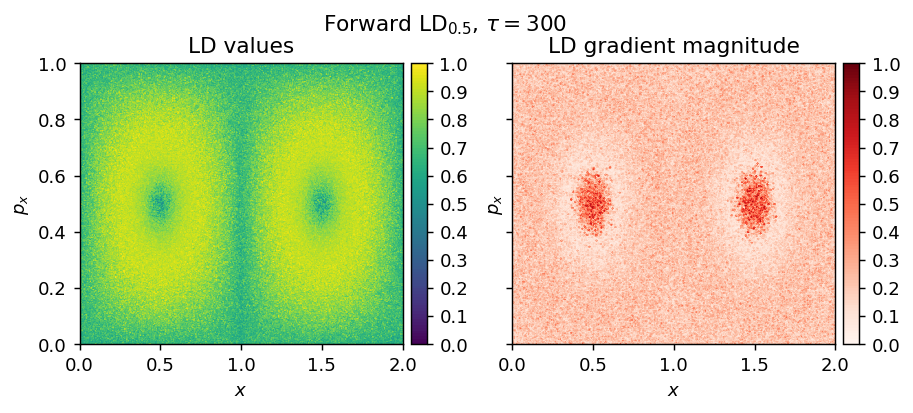

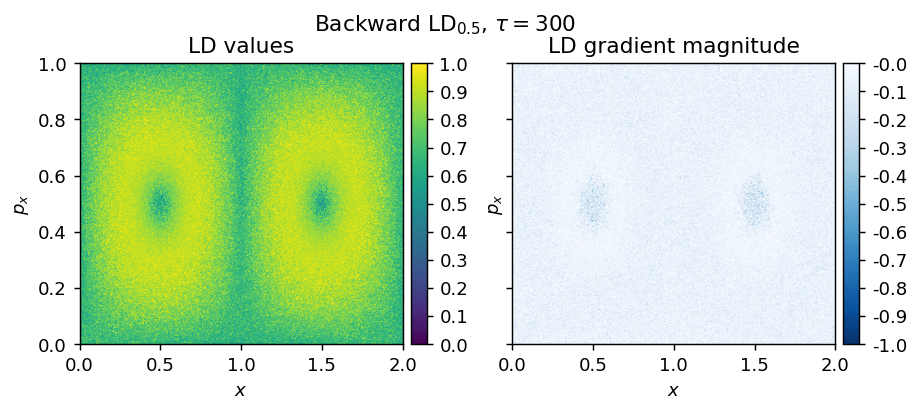

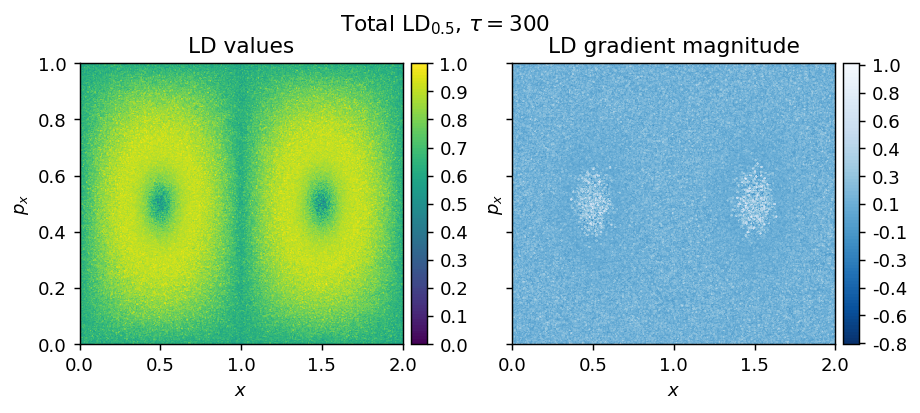

In [38]:
p = draw_all_lds(LD_forward, LD_backward, grid_parameters, N_iterations, p_value)

## TES: Several experiments

In [39]:
N_trials = 30

In [40]:
LD_total_trials = []

In [41]:
for n in range(N_trials):
    LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map_forward, N_iterations, p_value=0.5)
    LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map_backward, N_iterations, p_value=0.5)
    LD_total = LD_forward + LD_backward
    
    LD_total_trials.append(LD_total)

In [42]:
LD_total_mean = np.array(LD_total_trials).mean(axis=0)

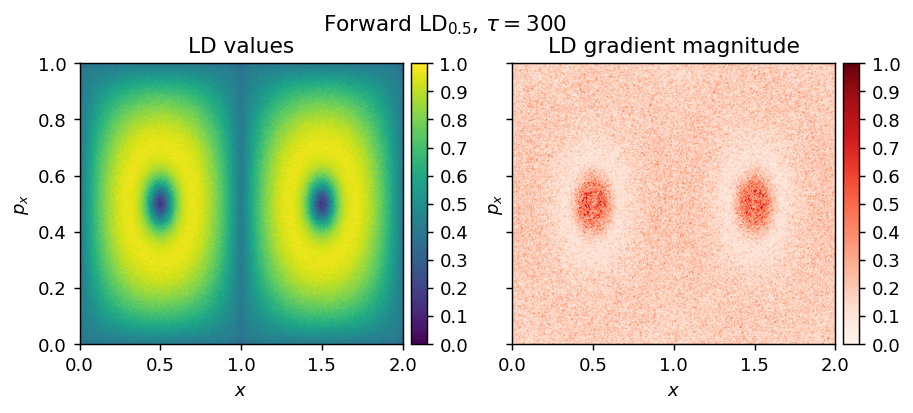

In [43]:
p = draw_all_lds(LD_total_mean, [], grid_parameters, N_iterations, p_value)

# Notes

* Check function `pruebaSLD.m` to check implementation.
* In `SLD.m` the vairable `dW` is generated as a normalised gaussian with $\mu = 0$ with std $\sqrt{\Delta t /2}$
* Integration is performed with RK4, not Euler-Maruyama (See output from Double Gyre. EM doesn't reproduce the correct LD output when noise amplitude is null)
* Check this for a Python implementation https://en.wikipedia.org/wiki/Milstein_method 

# Appendix

In [26]:
from pylab import *

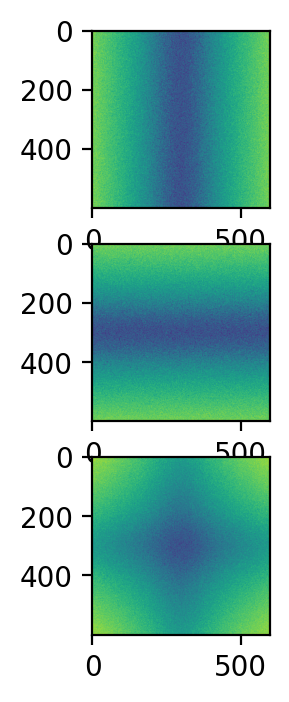

In [29]:
fig,ax = plt.subplots(3,1,dpi=200)
ax[0].imshow(LD_forward)
ax[1].imshow(LD_backward)
ax[2].imshow(LD_forward + LD_backward)
plt.show()

# Useful sources

* https://thomas-cokelaer.info/blog/2014/05/matplotlib-difference-between-pcolor-pcolormesh-and-imshow/

* https://en.wikipedia.org/wiki/Milstein_method an improvement of Euler-Maruyama

* https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/ Python implementation of Euler-Maruyama